# Environment Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_29_mask.tif
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_47.tif
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_28_mask.tif
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_7.tif
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38_mask.tif
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_19_mask.tif
/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_39.tif
/kaggle/inp

In [2]:
import os, cv2

import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

# Steps:
* Data Preparation
* 
* Data Visualization
* 
* Data Augmentaions
* 
* UNet
* 
* UNet+ Resnet(BackBone)
* 
* Train Models
* 
* Prediction on test data
* 
* Visualization of the prediction on test data

# Import Necessary Librarries

In [4]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

plt.style.use("dark_background")

In [5]:
# Path to all data
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

# Data¶
1. Creating a DataFrame

In [6]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md


dirname                                               path
0  TCGA_DU_6404_19850629  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_6404_19850629  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_6404_19850629  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_6404_19850629  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_6404_19850629  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

#  Masks/Not masks

In [7]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_44.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_44_mask.tif


# Final dataframe

In [8]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

patient  \
0     TCGA_DU_6404_19850629   
1     TCGA_DU_6404_19850629   
2     TCGA_DU_6404_19850629   
3     TCGA_DU_6404_19850629   
4     TCGA_DU_6404_19850629   
...                     ...   
3924  TCGA_DU_7309_19960831   
3925  TCGA_DU_7309_19960831   
3926  TCGA_DU_7309_19960831   
3927  TCGA_DU_7309_19960831   
3928  TCGA_DU_7309_19960831   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
...                                                 ...        ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  

[3929 rows x 4 columns]

# Data Distribution

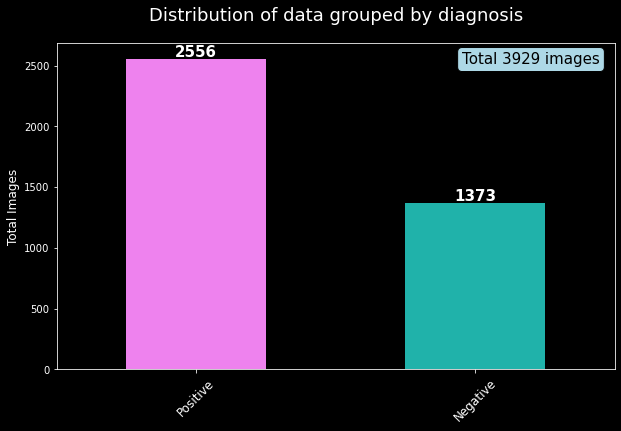

In [9]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );


# Distribution of positive/negative diagnosis between each patient

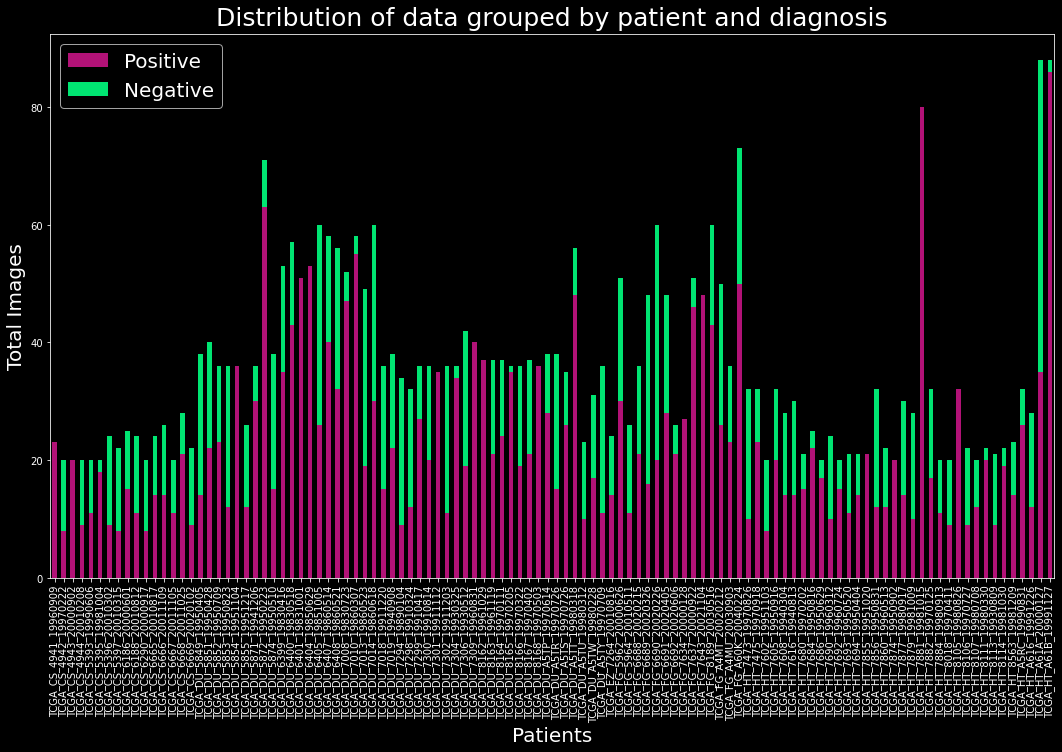

In [10]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

# Data Visualization
1. Samples of images with a positive and negative diagnosis

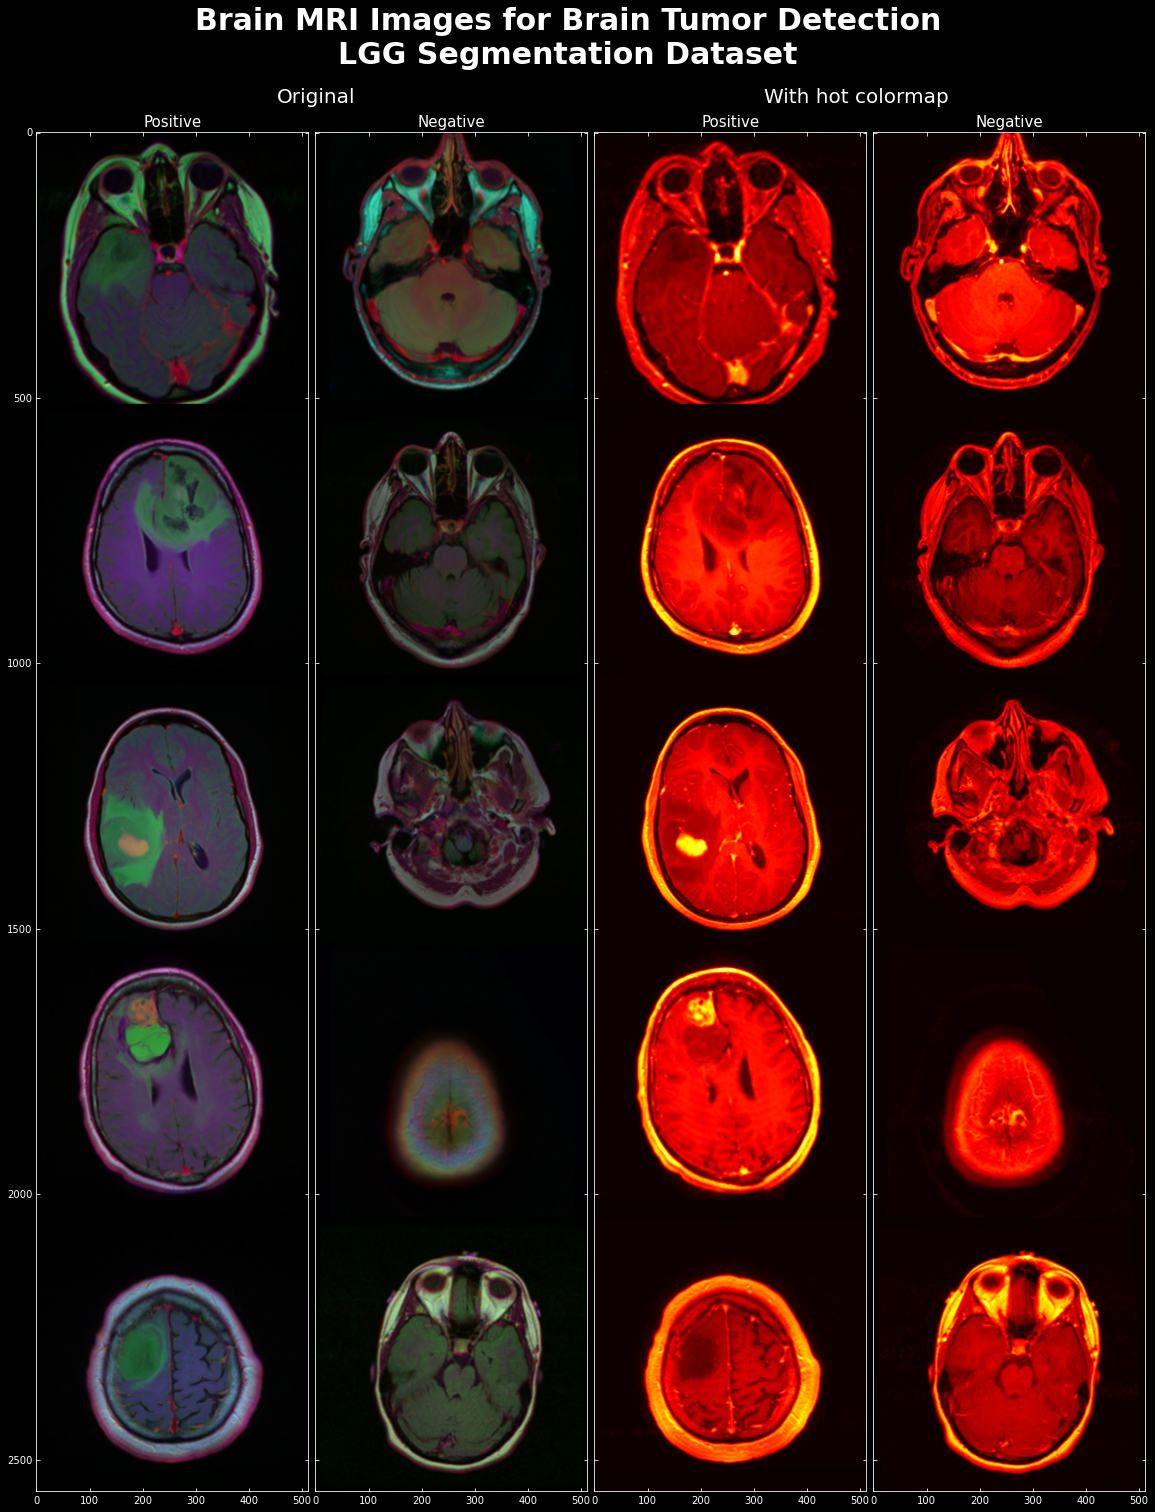

In [11]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

# Samples of images and masks with a positive diagnosis

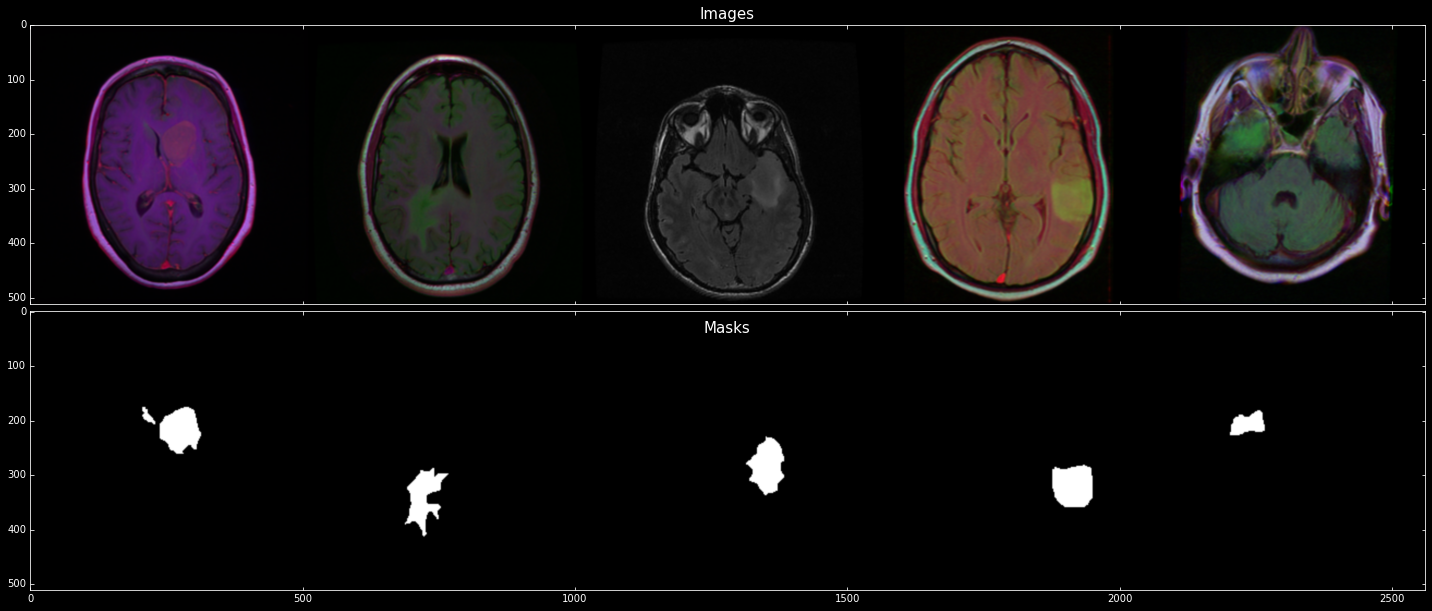

In [12]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()


# DataGenerator and Data Augmentation

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
 

In [16]:
PATCH_SIZE = 128

In [17]:
transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    A.Normalize(p=1.0),
    ToTensor(),
])

# Split data on train val test

In [18]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [19]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=True)

# Augmentation Visualization

torch.Size([16, 3, 128, 128]) torch.Size([16, 1, 128, 128])


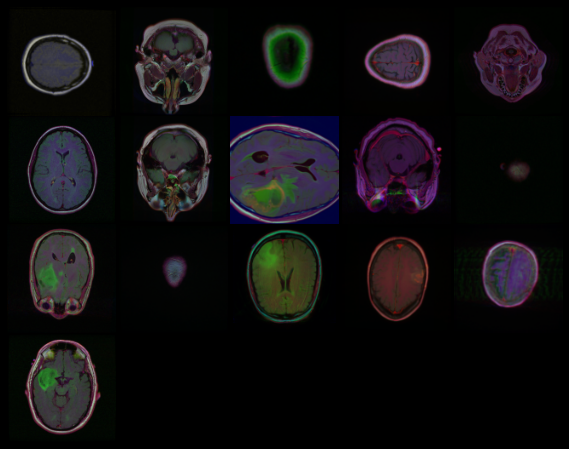

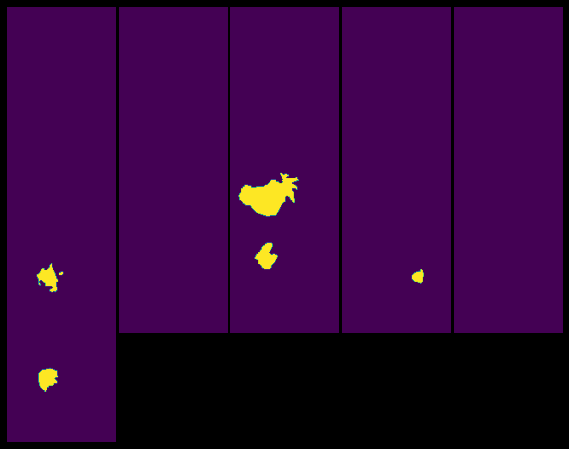

In [20]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

# DeeplabV3+ with ResNet50 backbone

In [21]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


In [22]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

In [23]:
# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [24]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [25]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-4,
)

# load best saved model checkpoint from previous commit (if present)
#if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
 #   model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [26]:
train_loader=train_dataloader

valid_loader=val_dataloader

# Train Models

In [27]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 25/25 [00:01<00:00, 15.24it/s, dice_loss - 0.783, iou_score - 0.3297]
Model saved!

Epoch: 1
valid: 100%|██████████| 25/25 [00:01<00:00, 14.11it/s, dice_loss - 0.4738, iou_score - 0.4892]
Model saved!

Epoch: 2
valid: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s, dice_loss - 0.3122, iou_score - 0.5969]
Model saved!

Epoch: 3
valid: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s, dice_loss - 0.2706, iou_score - 0.6326]
Model saved!

Epoch: 4
valid: 100%|██████████| 25/25 [00:01<00:00, 14.93it/s, dice_loss - 0.2364, iou_score - 0.6557]
Model saved!

Epoch: 5
valid: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s, dice_loss - 0.2353, iou_score - 0.6471]

Epoch: 6
valid: 100%|██████████| 25/25 [00:01<00:00, 16.81it/s, dice_loss - 0.2332, iou_score - 0.6501]

Epoch: 7
valid: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s, dice_loss - 0.2345, iou_score - 0.6476]

Epoch: 8
valid: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s, dice_loss - 0.213, iou_score - 

In [28]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    best_model = torch.load('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


# Predication , Evaluation & Performance Visulaization

In [29]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 34/34 [00:02<00:00, 16.92it/s, dice_loss - 0.1637, iou_score - 0.7411]
Evaluation on Test Data: 
Mean IoU Score: 0.7411
Mean Dice Loss: 0.1637


In [30]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5   \
dice_loss  0.899493  0.572870  0.358999  0.280867  0.239169  0.235878   
iou_score  0.126883  0.443919  0.568617  0.623383  0.658201  0.661033   

                 6         7         8         9   ...        20        21  \
dice_loss  0.215939  0.202033  0.190721  0.186522  ...  0.148066  0.150739   
iou_score  0.675886  0.694192  0.703351  0.709763  ...  0.752100  0.750818   

                 22        23        24        25        26        27  \
dice_loss  0.147299  0.159303  0.160185  0.149853  0.151481  0.151640   
iou_score  0.754162  0.739715  0.736522  0.751301  0.755261  0.749718   

                 28        29  
dice_loss  0.143844  0.137537  
iou_score  0.758290  0.766816  

[2 rows x 30 columns]

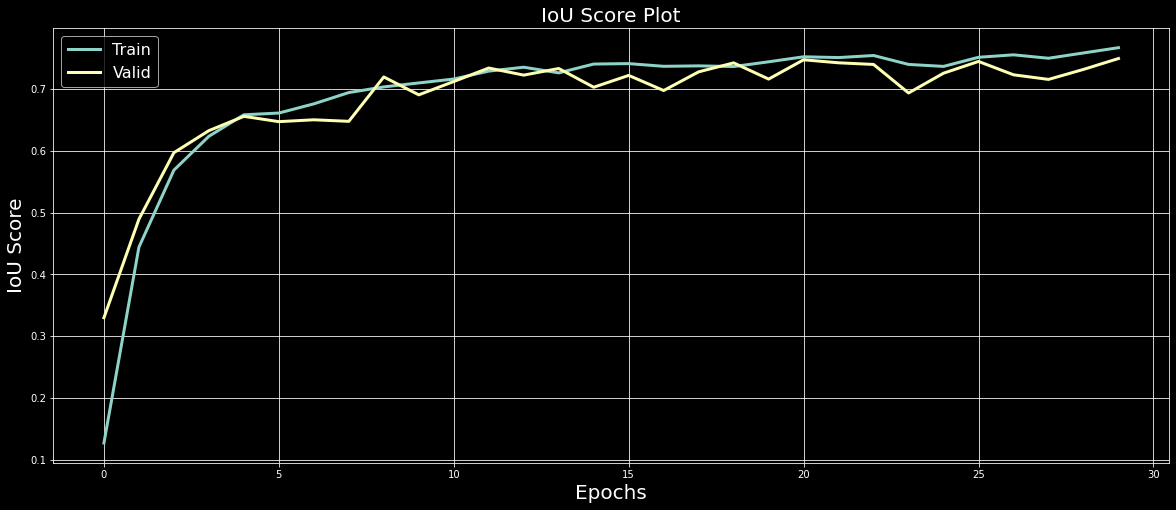

In [31]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

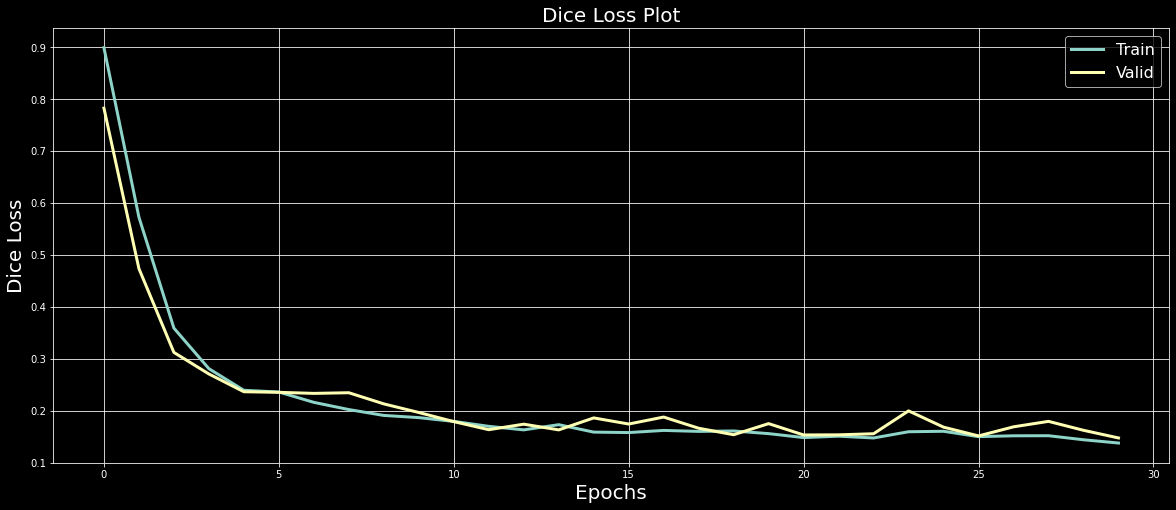

In [32]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()